# Prueba de Red Neuronal Artificial con Back Propagation

## Import de librerías

In [412]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import display
from sklearn.cluster import KMeans
import MySQLdb
#from pandas.io import sql
#from sqlalchemy import create_engine

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

## Configuración
### Conexión al DWH

In [413]:
# Base de datos histórica
dbname_hist = "ratio_dwh"
dbhost_hist = "localhost"
dbport_hist = 3306
dbuser_hist = "root"
dbpass_hist = "root"
table_hist = "events_hist"

## Extracción de datos del DWH

In [414]:
# Estrayendo valores de la tabla de eventos
conn = MySQLdb.connect(host=dbhost_hist, port=dbport_hist, user=dbuser_hist, passwd=dbpass_hist, db=dbname_hist)
df_events = pd.read_sql('select * from ' + table_hist, con=conn)
conn.close()

In [415]:
df_events.head(1)

,TIMESTAMP,YEARDAY,WEEKDAY,HOUR,MINUTE,MINDAY,TEMPERATURE,LIGHT,SOUND,MOVEMENT,LUX_ON,LUX_ACS,LIGHT_LUX,POT_ACS
0,2017-01-01,1,6,0,0,0,24.744444,4.0,35.635088,0.0,0,0.012527,4.0,0.003614


### Chequeo de valores null

In [416]:
# columnas con null
df_events.isnull().any()

TIMESTAMP      False
YEARDAY        False
WEEKDAY        False
HOUR           False
MINUTE         False
MINDAY         False
TEMPERATURE     True
LIGHT          False
SOUND          False
MOVEMENT       False
LUX_ON         False
LUX_ACS        False
LIGHT_LUX      False
POT_ACS        False
dtype: bool

#### Corrigiendo valores null
Podríamos utilizar diferentes opciones:
- pad: se rellena con el último valor
- interpolate: se rellena con valores interpolados de la columna (quizá el más apropiado para valores continuos). La interpolacion puede ser:
    - Lineal
    - Cuadratica
    - Cubica
- escalar: se rellena con un número específico

In [417]:
dftemp = pd.DataFrame(df_events.TEMPERATURE.interpolate(method='linear'), columns=['TEMP_L'] )
dftemp['TEMP_Q'] = df_events.TEMPERATURE.interpolate(method='quadratic')
dftemp['TEMP_C'] = df_events.TEMPERATURE.interpolate(method='cubic')

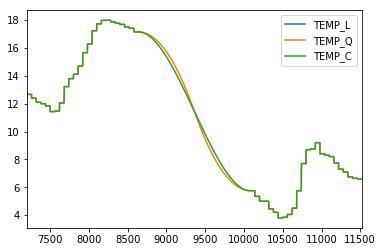

In [418]:
dftemp[7200:11520].plot()

Como las interpolaciones son similares, podría utilizarse cualquier método. En este caso usaremos la cuadrática.

In [419]:
df_events['TEMPERATURE'] = df_events.TEMPERATURE.interpolate(method='quadratic')

#### Verificación final de valores null

In [420]:
df_events.isnull().values.any()

False

### Verificando dataset completo
Para analizar un comportamiento predictivo y desarrollar un modelo es necesario contar con un dataset completo que no tenga saltos en las mediciones. Por lo tanto, se debe verificar que cuente con datos en todos los minutos del rango obtenido.

In [421]:
### TODO
# rellenar huecos de Timestamp
# promediar rows con mismo minuto
# rellenar mediciones agregadas con padding

## Limpieza del dataset
Debido a que no se necesitan todas las columnas para realizar el entrenamiento de la RNA, se eliminan las que no representen relación con lo que se busca predecir.
- TIMESTAMP
- YEARDAY
- HOUR
- MINUTE
- TEMPERATURE
- LIGHT
- LUX_ACS
- POT_AC

Las dimensiones TS, HOUR y MINUTE se pueden eliminar porque se representan con la dimensión MINDAY.

La dimensión YEARDAY simplemente no agregaría información para este tipo de entrenamiento.

Las mediciones TEMPERATURE y *_ACS pueden ignorarse para este tipo de entrenamiento.

La medición LIGHT no existe en la realidad (a menos que haya medición de luz externa)

In [422]:
del df_events['TIMESTAMP']
del df_events['YEARDAY']
del df_events['HOUR']
del df_events['MINUTE']
del df_events['TEMPERATURE']
del df_events['LIGHT']
del df_events['LUX_ACS']
del df_events['POT_ACS']

### Ajustes de variables
Se aplican ajustes y correcciones a las variables del dataset

In [423]:
df_events['MOVEMENT'] = df_events.MOVEMENT.astype(int)

## Análisis Exploratorio inicial

### Función de correlación
Hace una matriz de correlación entre las variables. Cuanto más claro el color, mayor correlación entre las variables. La diagonal debería ser amarilla, y representa la correlación de una variable con sí misma.

Esta función tiene dos entradas:
1. El dataframe panda a analizar
2. El tamáño de gráfico que se quiere imprimir

In [424]:
def plot_corr(df, size=6):
    corr = df.corr()    # data frame correlation function
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)   # color code the rectangles by correlation value
    plt.xticks(range(len(corr.columns)), corr.columns)  # draw x tick marks
    plt.yticks(range(len(corr.columns)), corr.columns)  # draw y tick marks

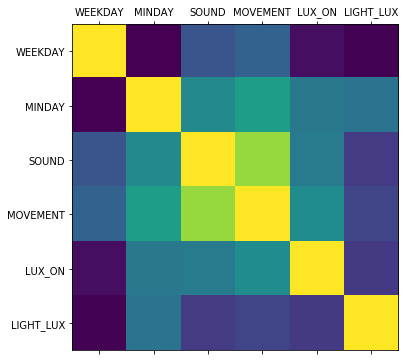

In [425]:
plot_corr(df_events)

In [426]:
df_events.corr()

,WEEKDAY,MINDAY,SOUND,MOVEMENT,LUX_ON,LIGHT_LUX
WEEKDAY,1.000000e+00,2.638810e-19,0.263127,0.316357,0.037642,0.007148
MINDAY,2.638810e-19,1.000000e+00,0.468927,0.562168,0.400641,0.380340
SOUND,2.631271e-01,4.689266e-01,1.000000,0.844178,0.410684,0.176000
MOVEMENT,3.163568e-01,5.621675e-01,0.844178,1.000000,0.486856,0.208396
LUX_ON,3.764213e-02,4.006405e-01,0.410684,0.486856,1.000000,0.169634
LIGHT_LUX,7.148032e-03,3.803397e-01,0.176000,0.208396,0.169634,1.000000


Debido a que no se puede ver una relación fuerte entre LUX_ON y el resto de los atributos, se procede a construir otro dataset a partir del obtenido con variables más significativas.

### Generación de nuevas variables
Se analizará la relación del estado de la luz (LUX_ON) con variables dependientes del dataset generado. El objetivo es intentar representar relaciones más adecuadas con el entorno tanto a nivel espacial como temporal.
Las mediciones (facts) a construir son:
- LIGHT_LUX_1m    medición de luz en el último minuto (sin contar la medición actual)
- MOVEMENT_1m     proporción del sensor PIR activado en el último minuto
- MOVEMENT_5m     proporción del sensor PIR activado en los últimos 5 minutos
- MOVEMENT_15m    proporción del sensor PIR activado en los últimos 15 minutos

Se sumarán al dataset actual manteniendo las dimensiones y mediciones previas:
- WEEKDAY
- MINDAY
- SOUND
- MOVEMENT
- LIGHT_LUX
- LUX_ON

In [427]:
df_events['LIGHT_LUX_1m'] = df_events.LIGHT_LUX.shift(1)
df_events['MOVEMENT_1m'] = df_events.MOVEMENT.shift(1)
df_events['MOVEMENT_5m'] = df_events.MOVEMENT.rolling(5).sum() / 5
df_events['MOVEMENT_15m'] = df_events.MOVEMENT.rolling(15).sum() / 15
df_events['LUX_SWITCH'] = df_events.LUX_ON.diff()
df_events.dropna(inplace=True)

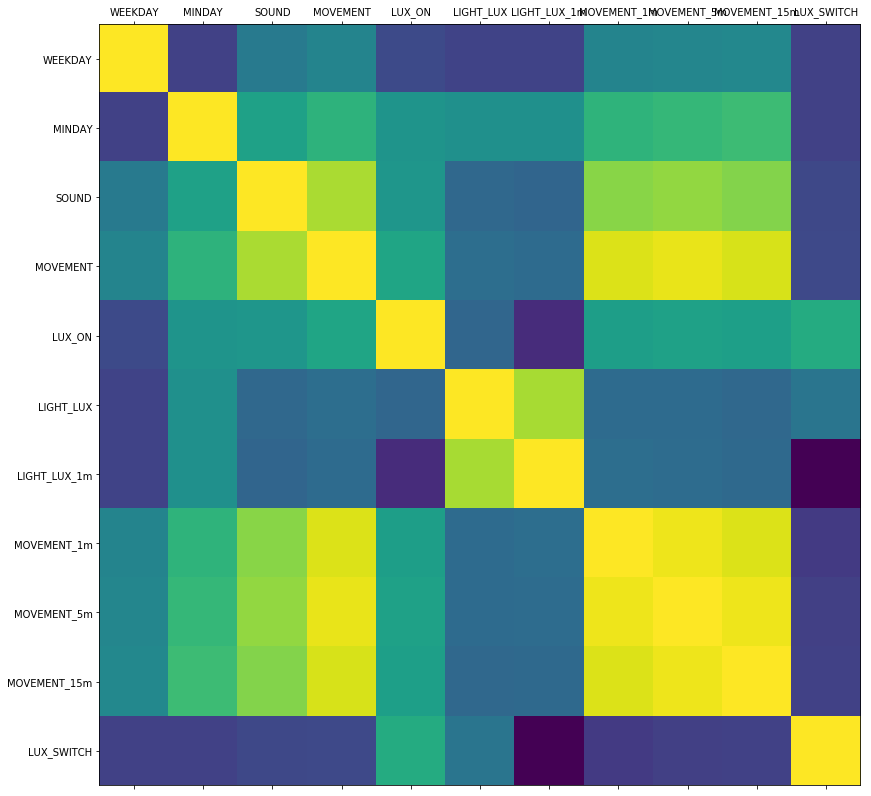

In [428]:
plot_corr(df_events,14)

In [429]:
df_events.corr()

,WEEKDAY,MINDAY,SOUND,MOVEMENT,LUX_ON,LIGHT_LUX,LIGHT_LUX_1m,MOVEMENT_1m,MOVEMENT_5m,MOVEMENT_15m,LUX_SWITCH
WEEKDAY,1.000000,0.000068,0.263165,0.316399,0.037639,0.007189,0.007215,0.316408,0.328029,0.336649,-0.000044
MINDAY,0.000068,1.000000,0.468916,0.562159,0.400668,0.380316,0.383263,0.563915,0.586417,0.611106,-0.000599
SOUND,0.263165,0.468916,1.000000,0.844176,0.410697,0.175987,0.161039,0.779348,0.796344,0.770911,0.029074
MOVEMENT,0.316399,0.562159,0.844176,1.000000,0.486870,0.208381,0.192878,0.933835,0.956638,0.924073,0.029961
LUX_ON,0.037639,0.400668,0.410697,0.486870,1.000000,0.169625,-0.083501,0.455680,0.468233,0.457330,0.522836
LIGHT_LUX,0.007189,0.380316,0.175987,0.208381,0.169625,1.000000,0.839055,0.190102,0.193423,0.179057,0.242778
LIGHT_LUX_1m,0.007215,0.383263,0.161039,0.192878,-0.083501,0.839055,1.000000,0.208380,0.197618,0.182138,-0.242070
MOVEMENT_1m,0.316408,0.563915,0.779348,0.933835,0.455680,0.190102,0.208380,1.000000,0.968693,0.932086,-0.029820
MOVEMENT_5m,0.328029,0.586417,0.796344,0.956638,0.468233,0.193423,0.197618,0.968693,1.000000,0.970660,-0.004869
MOVEMENT_15m,0.336649,0.611106,0.770911,0.924073,0.457330,0.179057,0.182138,0.932086,0.970660,1.000000,-0.003008


## Entrenamiento y verificación de RNA

### Variable objetivo: estado de la lámpara (LUX_ON)
La variable a predecir es LUX_ON, la cual está en 1 si la luz está prendida (sea estado override o no del módulo). La distribución del estado en porcentaje es la siguiente:

In [430]:
df_events.LUX_ON.value_counts(normalize=True)

0    0.831282
1    0.168718
Name: LUX_ON, dtype: float64

#### Separando los datos para training y prueba
Para poder hacer etapas de entrenamiento y prueba, voy a separar los datos. 70% para entrenamiento, 30% para prueba. Para esto voy a usar del módulo scikit-learn la función train_test_split.

Los conjuntos de datos van a llamarse:
* X_train: Datos de entrenamiento. Las 7 columnas con los valores del mes, día, sensores, etc, compuesto por el 70% de los registros
* y_train: Resultado de entrenamiento. Columna *estadoLuz* para el 70% de los registros
* X_test: Datos para hacer la validación. Tienen el mismo formato que X_train, pero corresponden al 30% del conjunto de datos
* y_test: Resultados para validar la performance del algoritmo aplicado a X_test

In [431]:
from sklearn.model_selection import train_test_split

luxState_feature_names = ['WEEKDAY', 'MINDAY', 'LIGHT_LUX_1m', 'SOUND', 'MOVEMENT', 'MOVEMENT_1m', 'MOVEMENT_5m', 'MOVEMENT_15m']
luxState_goal_names = ['LUX_ON']

luxState_features = df_events[luxState_feature_names].values     # Columnas del predictor (5 X m)
luxState_goal = df_events[luxState_goal_names].values            # Clase predecida (1=verdadero, 0=falso) column (1 X m)
split_test_size = 0.30                                           # 0.30 es 30%, el tamaño para pruebas

luxState_features_train, luxState_features_test, luxState_goal_train, luxState_goal_test = train_test_split(luxState_features, luxState_goal, test_size=split_test_size)

Verifico que el tamaño relativo de los sets de entrenamiento y prueba sea lo más cercano a 70-30 posible:

In [432]:
print "{0:.2f}% en el set de entrenamiento".format( (float(len(luxState_features_train))/len(df_events.index)) * 100 ) 
print "{0:.2f}% en el set de prueba".format((float(len(luxState_features_test))/len(df_events.index)) * 100)

70.00% en el set de entrenamiento
30.00% en el set de prueba


Verifico que la proporción de casos verdaderos y falsos se mantenga en los conjuntos de entrenamiento y test:

In [433]:
print("Lux Activo en el total           : {0} ({1:0.2f}%)".format(len(df_events.loc[df_events['LUX_ON'] == 1]), (len(df_events.loc[df_events['LUX_ON'] == 1])/float(len(df_events.index))) * 100.0))
print("Lux Inactivo en el total         : {0} ({1:0.2f}%)".format(len(df_events.loc[df_events['LUX_ON'] == 0]), (len(df_events.loc[df_events['LUX_ON'] == 0])/float(len(df_events.index))) * 100.0))
print("")
train_state_on = len(luxState_goal_train[ luxState_goal_train == 1])
train_state_off = len(luxState_goal_train[ luxState_goal_train == 0])
print("Lux Activo en entrenamiento      : {0} ({1:0.2f}%)".format(train_state_on, train_state_on/float(len(luxState_goal_train)) * 100.0))
print("Lux Inctivo en entrenamiento     : {0} ({1:0.2f}%)".format(train_state_off, train_state_off/float(len(luxState_goal_train)) * 100.0))
print("")
test_state_on = len(luxState_goal_test[ luxState_goal_test == 1])
test_state_off = len(luxState_goal_test[ luxState_goal_test == 0])
print("Lux Activo en test               : {0} ({1:0.2f}%)".format(test_state_on, test_state_on/float(len(luxState_goal_test)) * 100.0))
print("Lux Inctivo en test              : {0} ({1:0.2f}%)".format(test_state_off,test_state_off/float(len(luxState_goal_test)) * 100.0))

Lux Activo en el total           : 88676 (16.87%)
Lux Inactivo en el total         : 436910 (83.13%)

Lux Activo en entrenamiento      : 62000 (16.85%)
Lux Inctivo en entrenamiento     : 305910 (83.15%)

Lux Activo en test               : 26676 (16.92%)
Lux Inctivo en test              : 131000 (83.08%)


#### Entrenamiento inicial
Para este entrenamiento voy a usar otro módulo de scikit-learn: neural_network. Como lo que estamos tratando de averiguar es si la luz debe estar prendida o no, estamos hablando de un algoritmo de clasificación, y por lo tanto la función que voy a usar se llama MLPClassifier, e implementa un perceptrón multi capa (MLP) que se entrena usando backpropagation.


In [434]:
from sklearn.neural_network import MLPClassifier
clf_model_state = MLPClassifier()
%time clf_model_state.fit(luxState_features_train, luxState_goal_train.ravel())

Wall time: 12.3 s


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

#### Performance usando los datos de entrenamiento
Para esto voy a importar la función metrics.

In [435]:
from sklearn import metrics

clf_predict_state_train = clf_model_state.predict(luxState_features_train)

print("Precisión en entrenamiento: {0:.4f}".format(metrics.accuracy_score(luxState_goal_train, clf_predict_state_train)))

Precisión en entrenamiento: 0.8766


#### Performance usando los datos de prueba

In [436]:
clf_predict_state_test = clf_model_state.predict(luxState_features_test)

print("Precisión en test: {0:.4f}".format(metrics.accuracy_score(luxState_goal_test, clf_predict_state_test)))

Precisión en test: 0.8750


#### Métricas
Los resultados de las etapas de entrenamiento y prueba son muy buenos. Demasiado buenos. Hay que analizar si no hay algún otro problema que pueda causar que cuando ponga más datos (cuando analice en tiempo real la actividad del usuario), el modelo falle miserablemente.

Para este análisis, voy a ver como se comparan los resultados, con el objetivo de entender si el modelo sirve o hay que hacer ajustes. Voy a usar dos herramientas:

##### Matriz de confusión
https://es.wikipedia.org/wiki/Matriz_de_confusi%C3%B3n

Cada columna de la matriz representa el número de predicciones de cada clase, mientras que cada fila representa a las instancias en la clase real. Uno de los beneficios de las matrices de confusión es que facilitan ver si el sistema está confundiendo dos clases. 

En nuestro caso, la matriz representa lo siguiente:


| EV (Predicho Encendido y es verdad ) | EF (Predicho Encendido pero es falso) |
|------------------------------------------------|
| **AF (Predicho Apagado pero es Falso** | **AV (Predicho Apagado y es verdad)** |

Esto quiere decir que queremos los valores más altos posibles en la diagonal, y lo más cerca posible a cero en cualquier otro lado.

In [437]:
print("Matriz de confusión:")
print("{0}".format(metrics.confusion_matrix(luxState_goal_test, clf_predict_state_test, labels=[1, 0])))

Matriz de confusión:
[[ 13295  13381]
 [  6324 124676]]


Estos resultados son muy buenos, el porcentaje de acertados es altísimo. El modelo es casi perfecto. Para confirmar, hay que usar la otra herramienta.


#### Reporte de clasificación.
Lo primero que vamos a verificar es que tan bien se hace una predición acertada cuando se requiere que el dispositivo esté encendido. Este dato, llamado "recall" en el reporte, esta dado por:

Recall = EV / (EV + AF)

Lo segundo que queremos ver es la presición, que está dada por:

Precision = EV / (EV + EF)


In [438]:
print("Reporte de clasificación:")
print(metrics.classification_report(luxState_goal_test, clf_predict_state_test, labels=[1,0]))

Reporte de clasificación:
             precision    recall  f1-score   support

          1       0.68      0.50      0.57     26676
          0       0.90      0.95      0.93    131000

avg / total       0.86      0.88      0.87    157676



### Variable objetivo: cambio de estado de la lámpara (LUX_SWITCH)
La variable a predecir es LUX_SWITCH que se describe como cada cambio de estado del lux.
-  1: la luz se prendió
-  0: no hubo cambios
- -1: la luz se apagó
La distribución del estado en porcentaje es la siguiente:

In [439]:
df_events.LUX_SWITCH.value_counts(normalize=True)

 0.0    0.846644
-1.0    0.076678
 1.0    0.076678
Name: LUX_SWITCH, dtype: float64

#### Separando los datos para training y prueba

In [440]:
luxSwitch_feature_names = ['WEEKDAY', 'MINDAY', 'LIGHT_LUX_1m', 'SOUND', 'MOVEMENT', 'MOVEMENT_1m', 'MOVEMENT_5m', 'MOVEMENT_15m' ]
luxSwitch_goal_names = ['LUX_SWITCH']

luxSwitch_features = df_events[luxSwitch_feature_names].values        # Columnas predictoras
luxSwitch_goal = df_events[luxSwitch_goal_names].values               # Clase predecida (1, 0, -1)
split_test_size = 0.30                                                # 0.30 es 30%, el tamaño para pruebas

luxSwitch_feat_train, luxSwitch_feat_test, luxSwitch_goal_train, luxSwitch_goal_test = train_test_split(luxSwitch_features, luxSwitch_goal, test_size=split_test_size)

In [441]:
print "{0:.2f}% en el set de entrenamiento".format( (float(len(X_train))/len(df_events.index)) * 100 ) 
print "{0:.2f}% en el set de prueba".format((float(len(X_test))/len(df_events.index)) * 100)

70.00% en el set de entrenamiento
30.00% en el set de prueba


In [442]:
totales_switch_on = len(df_events.query('LUX_SWITCH == 1'))
totales_switch_stale = len(df_events.query('LUX_SWITCH == 0'))
totales_switch_off = len(df_events.query('LUX_SWITCH == -1'))
print 'Totales:'
print("Prendidas        : {0} ({1:0.2f}%)".format(totales_switch_on, totales_switch_on/float(df_events.shape[0]) * 100.0))
print("Sin cambios      : {0} ({1:0.2f}%)".format(totales_switch_stale, totales_switch_stale/float(df_events.shape[0]) * 100.0))
print("Apagadas         : {0} ({1:0.2f}%)".format(totales_switch_off, totales_switch_off/float(df_events.shape[0]) * 100.0))
print ''
train_switch_on = len(luxSwitch_goal_train[ luxSwitch_goal_train == 1])
train_switch_stale = len(luxSwitch_goal_train[ luxSwitch_goal_train == 0])
train_switch_off = len(luxSwitch_goal_train[ luxSwitch_goal_train == -1])
print 'Set de entrenamiento:'
print("Prendidas        : {0} ({1:0.2f}%)".format(train_switch_on, train_switch_on/float(luxSwitch_goal_train.shape[0]) * 100.0))
print("Sin cambios      : {0} ({1:0.2f}%)".format(train_switch_stale, train_switch_stale/float(luxSwitch_goal_train.shape[0]) * 100.0))
print("Apagadas         : {0} ({1:0.2f}%)".format(train_switch_off, train_switch_off/float(luxSwitch_goal_train.shape[0]) * 100.0))
print ''
test_switch_on = len(luxSwitch_goal_test[ luxSwitch_goal_test == 1])
test_switch_stale = len(luxSwitch_goal_test[ luxSwitch_goal_test == 0])
test_switch_off = len(luxSwitch_goal_test[ luxSwitch_goal_test == -1])
print 'Set de pruebas:'
print("Prendidas        : {0} ({1:0.2f}%)".format(test_switch_on, test_switch_on/float(luxSwitch_goal_test.shape[0]) * 100.0))
print("Sin cambios      : {0} ({1:0.2f}%)".format(test_switch_stale, test_switch_stale/float(luxSwitch_goal_test.shape[0]) * 100.0))
print("Apagadas         : {0} ({1:0.2f}%)".format(test_switch_off, test_switch_off/float(luxSwitch_goal_test.shape[0]) * 100.0))

Totales:
Prendidas        : 40301 (7.67%)
Sin cambios      : 444984 (84.66%)
Apagadas         : 40301 (7.67%)

Set de entrenamiento:
Prendidas        : 28287 (7.69%)
Sin cambios      : 311317 (84.62%)
Apagadas         : 28306 (7.69%)

Set de pruebas:
Prendidas        : 12014 (7.62%)
Sin cambios      : 133667 (84.77%)
Apagadas         : 11995 (7.61%)


#### Entrenamiento inicial

In [443]:
clf_model_switch = MLPClassifier()
%time clf_model_switch.fit(luxSwitch_feat_train, luxSwitch_goal_train.ravel())

Wall time: 3min 54s


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

#### Performance usando los datos de entrenamiento

In [444]:
clf_predict_switch_train = clf_model_switch.predict(luxSwitch_feat_train)

print("Precisión en entrenamiento: {0:.4f}".format(metrics.accuracy_score(luxSwitch_goal_train, clf_predict_switch_train)))

Precisión en entrenamiento: 0.8843


#### Performance usando los datos de prueba

In [445]:
clf_predict_switch_test = clf_model_switch.predict(luxSwitch_feat_test)

print("Precisión en test: {0:.4f}".format(metrics.accuracy_score(luxSwitch_goal_test, clf_predict_switch_test)))

Precisión en test: 0.8847


#### Métricas
##### Matriz de confusión

In [446]:
print("{0}".format(metrics.confusion_matrix(luxSwitch_goal_test, clf_predict_switch_test, labels=[1, 0, -1])))

[[  6670   5343      1]
 [  2851 130561    255]
 [     0   9732   2263]]


#### Reporte de clasificación

In [447]:
print(metrics.classification_report(luxSwitch_goal_test, clf_predict_switch_test, labels=[1,0,-1]))

             precision    recall  f1-score   support

          1       0.70      0.56      0.62     12014
          0       0.90      0.98      0.93    133667
         -1       0.90      0.19      0.31     11995

avg / total       0.88      0.88      0.86    157676



## Validación del modelo

### Predicción de ESTADO (LUX_ON)
Features:

| WEEKDAY | MINDAY | LIGHT_LUX_1m | SOUND | MOVEMENT | MOVEMENT_1m | MOVEMENT_5m | MOVEMENT_15m |
|-----------------------------------------------------------------------------------------------|
| 0-6 | 0-1439 | 0-2000 | 30-130 | 0/1 | 0-1 | 0-1 | 0-1 |

In [448]:
X_new_test = pd.DataFrame([[ 5, 670, 85, 50, 1, 1, 1, 0.9 ]],columns=luxState_feature_names)

In [449]:
clf_predict_new_test = clf_model_state.predict(X_new_test)

print ("Resultado: ", clf_predict_new_test)

('Resultado: ', array([1], dtype=int64))


### Predicción de CAMBIO DE ESTADO (LUX_SWITCH)

Features:

| WEEKDAY | MINDAY | LIGHT_LUX_1m | SOUND | MOVEMENT | MOVEMENT_1m | MOVEMENT_5m | MOVEMENT_15m |
|-----------------------------------------------------------------------------------------------|
| 0-6 | 0-1439 | 0-2000 | 30-130 | 0/1 | 0-1 | 0-1 | 0-1 |

In [450]:
X_new_test = pd.DataFrame([[ 5, 670, 85, 50, 1, 1, 1, 0.9 ]],columns=luxSwitch_feature_names)

In [451]:
clf_predict_new_test = clf_model_switch.predict(X_new_test)

print ("Resultado: ", clf_predict_new_test)

('Resultado: ', array([ 1.]))
